In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout,Resizing,Input,Normalization
from keras import models
from keras.models import Sequential
from IPython import display

In [2]:
DATASET_PATH = 'data/'
data_dir = pathlib.Path(DATASET_PATH)
main_folder = tf.io.gfile.listdir(str(data_dir)) #this command show us every folder in the folder that is main

commands = np.array(main_folder)

commands = commands[(commands != 'donateacry_corpus') & (commands !=  'archive(3).zip')] #we are dealet some folderes
print(commands)

['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']


In [3]:
#Making dataset
X_train, X_test = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir, #adrees of our dataset
    batch_size=64, #reading the trcks in the packes with number 64
    validation_split=0.2, #this is our test
    seed=0, # this is for choosing random 
    output_sequence_length=16000*8, #this is the length and in this project this number equal to sampelrate and it means we have 1 second of audio
    subset='both')

label_names = np.array(X_train.class_names)
print()
print("label :", label_names)

Found 457 files belonging to 6 classes.
Using 366 files for training.
Using 91 files for validation.



label : ['belly_pain' 'burping' 'discomfort' 'donateacry_corpus' 'hungry' 'tired']


In [4]:
#Comperesing train and test
def squeeze(audio,labels):
    audio = tf.squeeze(audio,axis=-1)
    return audio,labels
X_train = X_train.map(squeeze, tf.data.AUTOTUNE)
X_test= X_test.map(squeeze, tf.data.AUTOTUNE)

In [5]:
val=X_test
X_test = X_test.shard(num_shards=2, index=0)
val = X_test.shard(num_shards=2, index=1)


for x, y in X_train.take(1):  # 1 in this commadn means tha choose on fo that bach that has 64 audio on it
  print(x)
  print(label_names[y])

for example_audio, example_labels in X_train.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

tf.Tensor(
[[ 3.0517578e-04  9.7656250e-04  4.8828125e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.1879883e-04  1.5258789e-04 -6.1035156e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]], shape=(64, 128000), dtype=float32)
['burping' 'hungry' 'hungry' 'discomfort' 'hungry' 'belly_pain' 'hungry'
 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'tired' 'tired'
 'discomfort' 'hungry' 'hungry' 'hungry' 'hungry' 'hungry' 'burping'
 'hungry' 'hungry' 'belly_pain' 'hungry' 'hungry' 'hungry' 'hungry'
 'hungry' 'hungry' 'hungry' 'tired' 'burping' 'hungry' 'hungry' 'hungry'

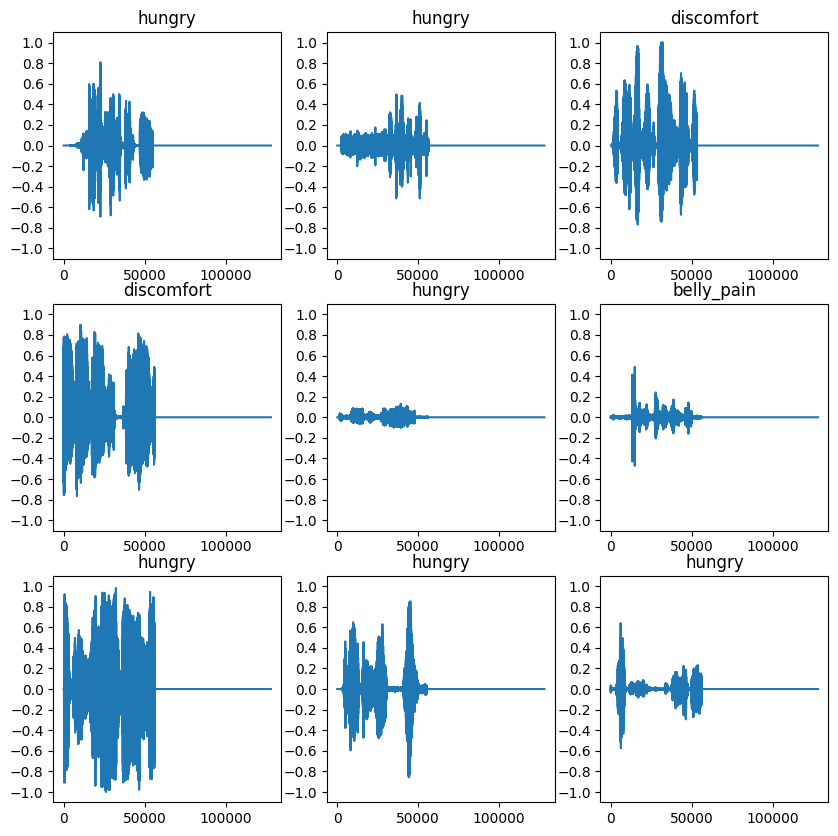

In [6]:
plt.figure(figsize=(10, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [7]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]  #in this command we add forth dimention
  return spectrogram

In [9]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:',label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: hungry
Waveform shape: (128000,)
Spectrogram shape: (999, 129, 1)
Audio playback


Label: hungry
Waveform shape: (128000,)
Spectrogram shape: (999, 129, 1)
Audio playback


Label: discomfort
Waveform shape: (128000,)
Spectrogram shape: (999, 129, 1)
Audio playback


In [10]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1) 
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

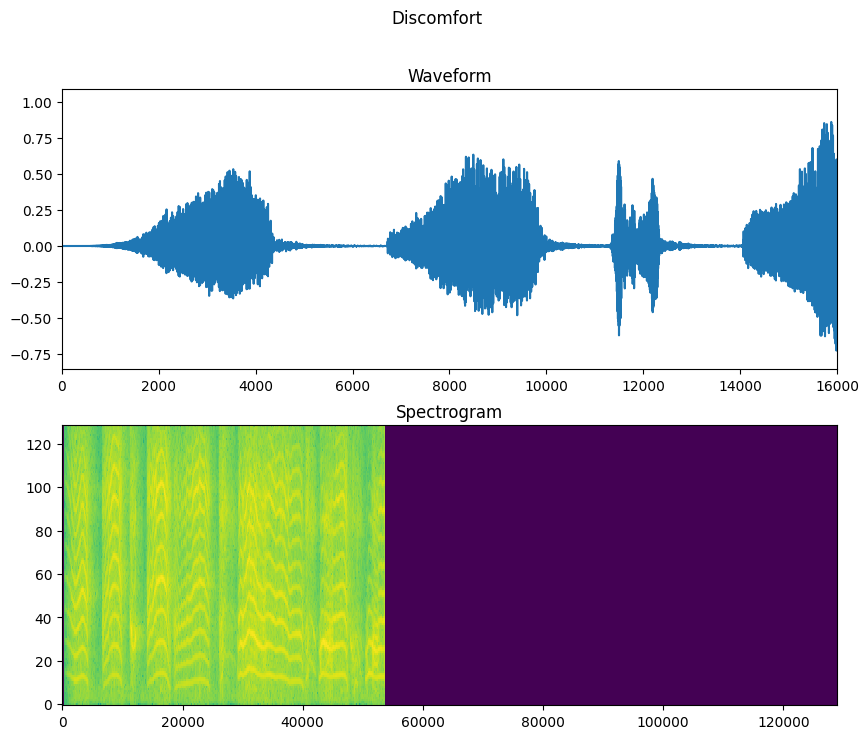

In [11]:
plt.close()
fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

plt.suptitle(label.title())
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [12]:
#Making dataset Spectrom
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_spectrogram_ds = make_spec_ds(X_train)
val_spectrogram_ds = make_spec_ds(val)
test_spectrogram_ds = make_spec_ds(X_test)

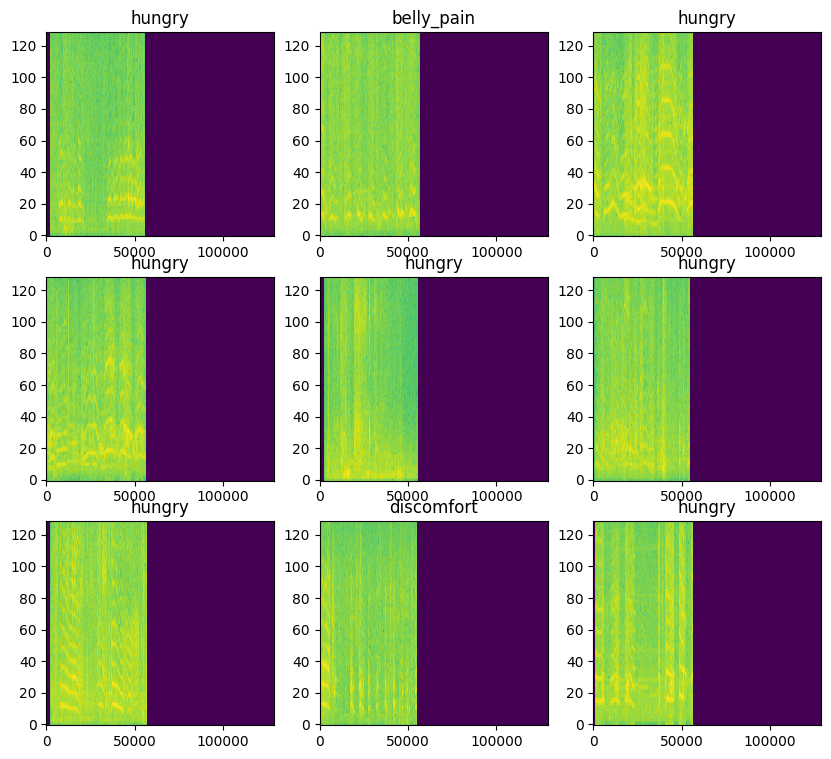

In [14]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [15]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [16]:
example_spectrograms.shape[1:]

TensorShape([999, 129, 1])

In [17]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names) #for our output number of dense
 
norm_layer = Normalization() 
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    Input(shape=input_shape),
    # Downsample the input.
    Resizing(32, 32),
    # Normalize.
    norm_layer,
    Conv2D(32, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25), #Dropout is making noise in deep model and help to increas accuracy and stop overfiting
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6),
])

model.summary()

Input shape: (999, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [19]:
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2), #call back is for when we stop it we can continue fit our model
)

Epoch 1/10
6/6 [==============================] - 3s 163ms/step - loss: 1.4055 - accuracy: 0.7240
Epoch 2/10
6/6 [==============================] - 1s 206ms/step - loss: 0.8380 - accuracy: 0.8279
Epoch 3/10
6/6 [==============================] - 1s 195ms/step - loss: 0.7320 - accuracy: 0.8279
Epoch 4/10
6/6 [==============================] - 1s 176ms/step - loss: 0.6857 - accuracy: 0.8306
Epoch 5/10
6/6 [==============================] - 1s 178ms/step - loss: 0.6855 - accuracy: 0.8306
Epoch 6/10
6/6 [==============================] - 1s 181ms/step - loss: 0.6599 - accuracy: 0.8306
Epoch 7/10
6/6 [==============================] - 1s 170ms/step - loss: 0.6035 - accuracy: 0.8306
Epoch 8/10
6/6 [==============================] - 1s 171ms/step - loss: 0.5787 - accuracy: 0.8306
Epoch 9/10
6/6 [==============================] - 1s 198ms/step - loss: 0.5420 - accuracy: 0.8388
Epoch 10/10
6/6 [==============================] - 1s 186ms/step - loss: 0.5124 - accuracy: 0.8525


In [20]:
model.evaluate(test_spectrogram_ds, return_dict=True) #with this command we can understand the accuracy of model in test 

1/1 [==============================] - 1s 1s/step - loss: 0.5839 - accuracy: 0.9062


{'loss': 0.5838718414306641, 'accuracy': 0.90625}

In [21]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 0s 408ms/step


In [22]:
y_pred = tf.argmax(y_pred, axis=1)

In [23]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

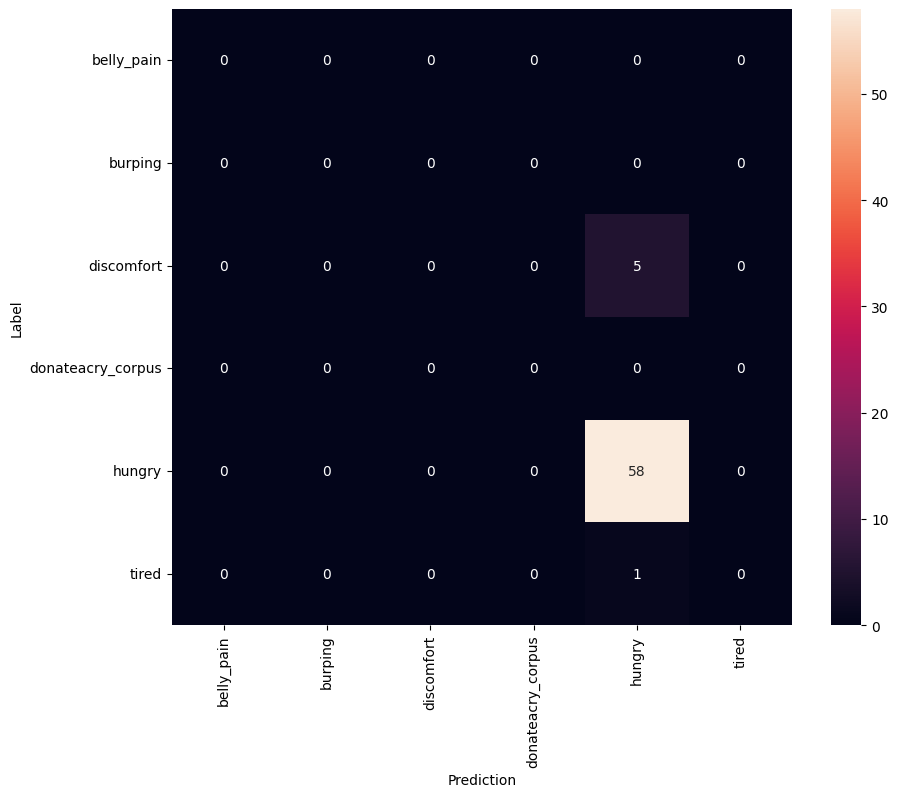

In [24]:
# Comparing the real command and the command that your ai predict showing in a heatmap
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()